# Задача 1: BatchNorm

In [1]:
import torch

class BatchNorm1d:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(num_features, requires_grad=True)
        self.beta = torch.zeros(num_features, requires_grad=True)
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def forward(self, x, training=True):
        original_dim = x.dim()
        # (N, F) для 1d, (N, C, H, W) для 2d (нормализация по батчу/пространству)
        if original_dim == 2:
            dim = 0
            permuted = False
        elif original_dim == 4:
            x = x.permute(0, 2, 3, 1)
            dim = (0, 1, 2)
            permuted = True
        else:
            raise ValueError(f"Unsupported input shape: {x.shape}")
        
        batch_mean = x.mean(dim=dim, keepdim=permuted)
        batch_var = x.var(dim=dim, unbiased=False, keepdim=permuted)
        
        # Обновление running stats в training
        if training:
            with torch.no_grad():
                if x.dim() == 2:
                    update_mean = batch_mean
                    update_var = batch_var
                else:
                    update_mean = batch_mean.squeeze((0, 1, 2))
                    update_var = batch_var.squeeze((0, 1, 2))
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * update_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * update_var
        
        # Нормализация: batch stats в training, running в eval
        if not training:
            if x.dim() == 2:
                mean_view = self.running_mean.view(1, -1)
                var_view = self.running_var.view(1, -1)
            else:
                mean_view = self.running_mean.view(1, 1, 1, -1)
                var_view = self.running_var.view(1, 1, 1, -1)
            batch_mean = mean_view.expand_as(x)
            batch_var = var_view.expand_as(x)
        
        x_norm = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        # Broadcasting gamma/beta
        if x.dim() == 2:
            gamma_exp = self.gamma.view(1, -1).expand_as(x)
            beta_exp = self.beta.view(1, -1).expand_as(x)
        else:
            gamma_exp = self.gamma.view(1, 1, 1, -1).expand_as(x)
            beta_exp = self.beta.view(1, 1, 1, -1).expand_as(x)
        out = gamma_exp * x_norm + beta_exp
        
        # Восстанавливаем оригинальную форму для 4D
        if permuted:
            out = out.permute(0, 3, 1, 2)
        
        return out

    def __call__(self, x, training=True):
        return self.forward(x, training)

In [2]:
bn = BatchNorm1d(3)
x = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], requires_grad=True)
print("Input:\n", x)

out = bn(x, training=True)
print("Output (train):\n", out)
print(out.mean(0))
print(out.var(0, unbiased=False))

out_eval = bn(x, training=False)
print("Output (eval):\n", out_eval)

Input:
 tensor([[1., 2., 3.],
        [4., 5., 6.]], requires_grad=True)
Output (train):
 tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000]], grad_fn=<AddBackward0>)
tensor([0., 0., 0.], grad_fn=<MeanBackward1>)
tensor([1.0000, 1.0000, 1.0000], grad_fn=<VarBackward0>)
Output (eval):
 tensor([[0.7071, 1.5556, 2.4042],
        [3.5355, 4.3840, 5.2326]], grad_fn=<AddBackward0>)


# Задача 2: Linear

In [3]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weight = torch.randn(out_features, in_features, requires_grad=True) * 0.01  # Xavier-like init
        if bias:
            self.bias = torch.zeros(out_features, requires_grad=True)

    def forward(self, x):
        # x: (batch, in) или (batch, seq, in)
        if x.dim() == 2:
            out = x @ self.weight.T
        else:
            out = torch.bmm(x, self.weight.T.unsqueeze(0).expand(x.size(0), -1, -1))  # Для seq
        if self.bias is not None:
            out += self.bias
        return out

    def __call__(self, x):
        return self.forward(x)

In [4]:
lin = Linear(2, 3)
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
print(lin(x).shape)

torch.Size([2, 3])


# Задача 3: Dropout

In [5]:
class Dropout:
    def __init__(self, p=0.5):
        self.p = p
        self.mask = None

    def forward(self, x, training=True):
        if not training:
            return x
        self.mask = (torch.rand_like(x) > self.p).float()
        out = x * self.mask / (1 - self.p)
        return out

    def __call__(self, x, training=True):
        return self.forward(x, training)

In [6]:
drop = Dropout(0.5)
x = torch.ones(2, 3)
out = drop(x, training=True)
print(out)
out2 = drop(x, training=False)

tensor([[0., 2., 0.],
        [2., 0., 0.]])


# Задача 4: Активации

In [7]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, x):
        return torch.clamp(x, min=0)

    def __call__(self, x):
        return self.forward(x)

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

    def __call__(self, x):
        return self.forward(x)

# Softmax (dim=-1 по умолчанию)
class Softmax:
    def __init__(self, dim=-1):
        self.dim = dim

    def forward(self, x):
        exp_x = torch.exp(x - torch.max(x, dim=self.dim, keepdim=True)[0])
        return exp_x / exp_x.sum(dim=self.dim, keepdim=True)

    def __call__(self, x):
        return self.forward(x)

In [8]:
relu = ReLU()
x_neg = torch.tensor([-1.0, 0.0, 1.0])
print(relu(x_neg))

sig = Sigmoid()
print(sig(x_neg))

sm = Softmax()
print(sm(torch.tensor([[1.0, 2.0, 3.0]])))

tensor([0., 0., 1.])
tensor([0.2689, 0.5000, 0.7311])
tensor([[0.0900, 0.2447, 0.6652]])


# Задание 2: Медианный фильтр

Kernel 3: min=0.000, max=1.000, mean=0.493
Kernel 5: min=0.149, max=0.881, mean=0.495
Kernel 10: min=0.319, max=0.684, mean=0.487


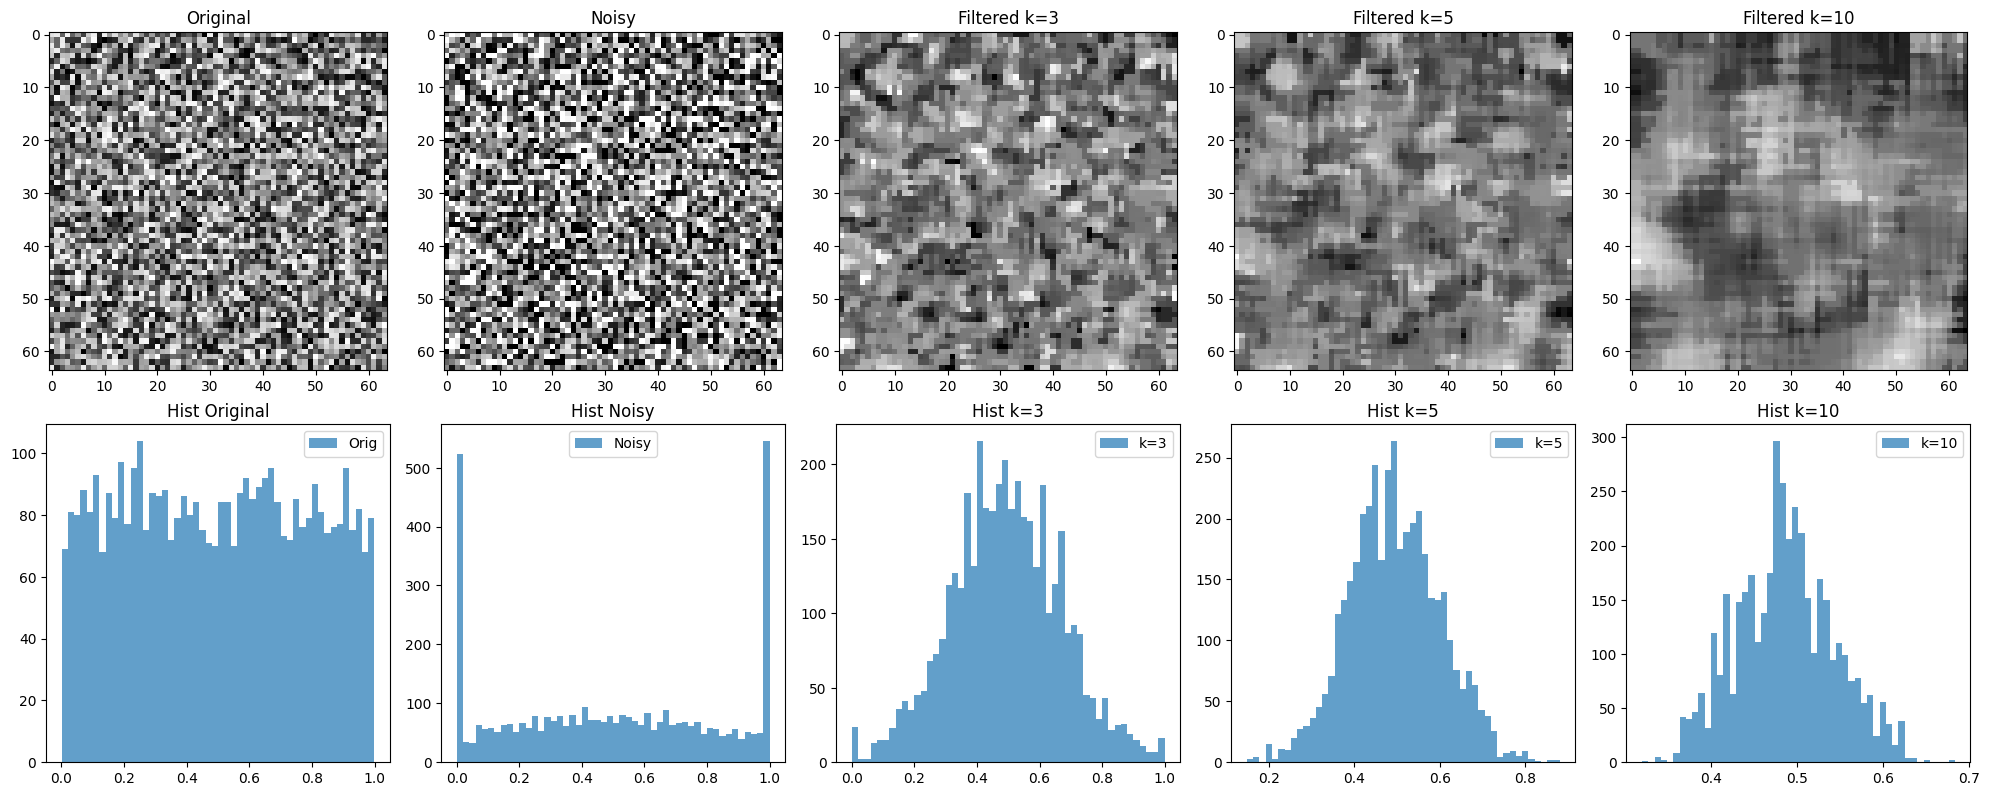

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def median_filter(img, kernel_size):
    C, H, W = img.shape
    k = kernel_size
    pad = k // 2
    padded = F.pad(img, (pad, pad, pad, pad), mode='reflect')  # (C, H+k-1, W+k-1)
    
    out = torch.zeros_like(img)
    
    for i in range(H):
        for j in range(W):
            window = padded[:, i:i+k, j:j+k]  # (C, k, k)
            window_flat = window.reshape(C, -1)
            median = torch.median(window_flat, dim=1)[0]  # Медиана по окну для каждого канала (C,)
            out[:, i, j] = median
    return out

# Сгенерируем шумное изображение
torch.manual_seed(42)
img = torch.rand(1, 64, 64)  # Grayscale-like (C=1)
noisy = img + 0.3 * torch.randn_like(img)
noisy = torch.clamp(noisy, 0, 1)

fig, axs = plt.subplots(2, 5, figsize=(20, 8))

axs[0, 0].imshow(img[0], cmap='gray')
axs[0, 0].set_title('Original')
axs[0, 1].imshow(noisy[0], cmap='gray')
axs[0, 1].set_title('Noisy')

axs[1, 0].hist(img[0].flatten(), bins=50, alpha=0.7, label='Orig')
axs[1, 0].set_title('Hist Original')
axs[1, 0].legend()

axs[1, 1].hist(noisy[0].flatten(), bins=50, alpha=0.7, label='Noisy')
axs[1, 1].set_title('Hist Noisy')
axs[1, 1].legend()

for idx, k in enumerate([3, 5, 10]):
    filtered = median_filter(noisy, k)
    col = 2 + idx  # 2,3,4
    axs[0, col].imshow(filtered[0], cmap='gray')
    axs[0, col].set_title(f'Filtered k={k}')
    print(f"Kernel {k}: min={filtered.min():.3f}, max={filtered.max():.3f}, mean={filtered.mean():.3f}")

    axs[1, col].hist(filtered[0].flatten(), bins=50, alpha=0.7, label=f'k={k}')
    axs[1, col].set_title(f'Hist k={k}')
    axs[1, col].legend()

plt.tight_layout()
plt.show()

# Задание 3: Трансформации

In [10]:
from PIL import Image
import torch
import numpy as np
import random
from typing import List
import torchvision.transforms.functional as TF

class BaseTransform:
    def __init__(self, p: float = 1.0):
        self.p = p

    def __call__(self, img: Image.Image) -> Image.Image:
        if random.random() < self.p:
            return self.transform(img)
        return img

    def transform(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError

class RandomCrop(BaseTransform):
    def __init__(self, p: float = 1.0, size=224):
        super().__init__(p)
        self.size = size

    def transform(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        if min(w, h) < self.size:
            raise ValueError("Image too small")
        left = random.randint(0, w - self.size)
        top = random.randint(0, h - self.size)
        return img.crop((left, top, left + self.size, top + self.size))

class RandomRotate(BaseTransform):
    def __init__(self, p: float = 1.0, degrees=15):
        super().__init__(p)
        self.degrees = degrees

    def transform(self, img: Image.Image) -> Image.Image:
        angle = random.uniform(-self.degrees, self.degrees)
        return img.rotate(angle, resample=Image.BILINEAR, expand=True)

class RandomZoom(BaseTransform):
    def __init__(self, p: float = 1.0, zoom_range=(0.8, 1.2)):
        super().__init__(p)
        self.zoom_min, self.zoom_max = zoom_range

    def transform(self, img: Image.Image) -> Image.Image:
        zoom = random.uniform(self.zoom_min, self.zoom_max)
        w, h = img.size
        new_w, new_h = int(w * zoom), int(h * zoom)
        resized = img.resize((new_w, new_h), Image.BILINEAR)
        left = (new_w - w) // 2
        top = (new_h - h) // 2
        return resized.crop((left, top, left + w, top + h))

class ToTensor(BaseTransform):
    def __init__(self, p: float = 1.0):
        super().__init__(p)

    def __call__(self, img: Image.Image) -> torch.Tensor:
        arr = np.array(img).astype(np.float32) / 255.0
        if len(arr.shape) == 2:
            arr = np.expand_dims(arr, 0)
        tensor = torch.from_numpy(arr.transpose(2, 0, 1))
        return tensor

class Compose:
    def __init__(self, transforms: List[BaseTransform]):
        self.transforms = transforms

    def __call__(self, img: Image.Image) -> torch.Tensor:
        for t in self.transforms:
            img = t(img)
        return img

In [11]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

img = Image.new('RGB', (256, 256), color='red')

# Граничные: p=0 -> original
comp_no = Compose([RandomCrop(0.0), ToTensor()])
print(comp_no(img).sum() == torch.tensor([256*256*3]).float())

# p=1, fixed seed -> reproducible
comp_yes = Compose([RandomRotate(1.0, degrees=0), ToTensor()])  # degrees=0 -> без изменений
out1 = comp_yes(img)
out2 = comp_yes(img)
assert torch.equal(out1, out2)

# Граница: small img for crop
small_img = Image.new('RGB', (10,10), 'blue')
try:
    RandomCrop(1.0, size=20)(small_img)
except ValueError:
    print("Handled small img")

# Zoom <1 -> ok, >1 crop back
zoom = RandomZoom(1.0, (0.5, 2.0))
zoomed = zoom(img)
assert zoomed.size == img.size

tensor([False])
Handled small img


# Задание 4: Применение трансформаций

Files already downloaded and verified
Files already downloaded and verified
Using synthetic: False
Running case 0...
Files already downloaded and verified
Files already downloaded and verified
Running case 1...
Files already downloaded and verified
Files already downloaded and verified
Running case 2...
Files already downloaded and verified
Files already downloaded and verified
Running case 3...
Files already downloaded and verified
Files already downloaded and verified


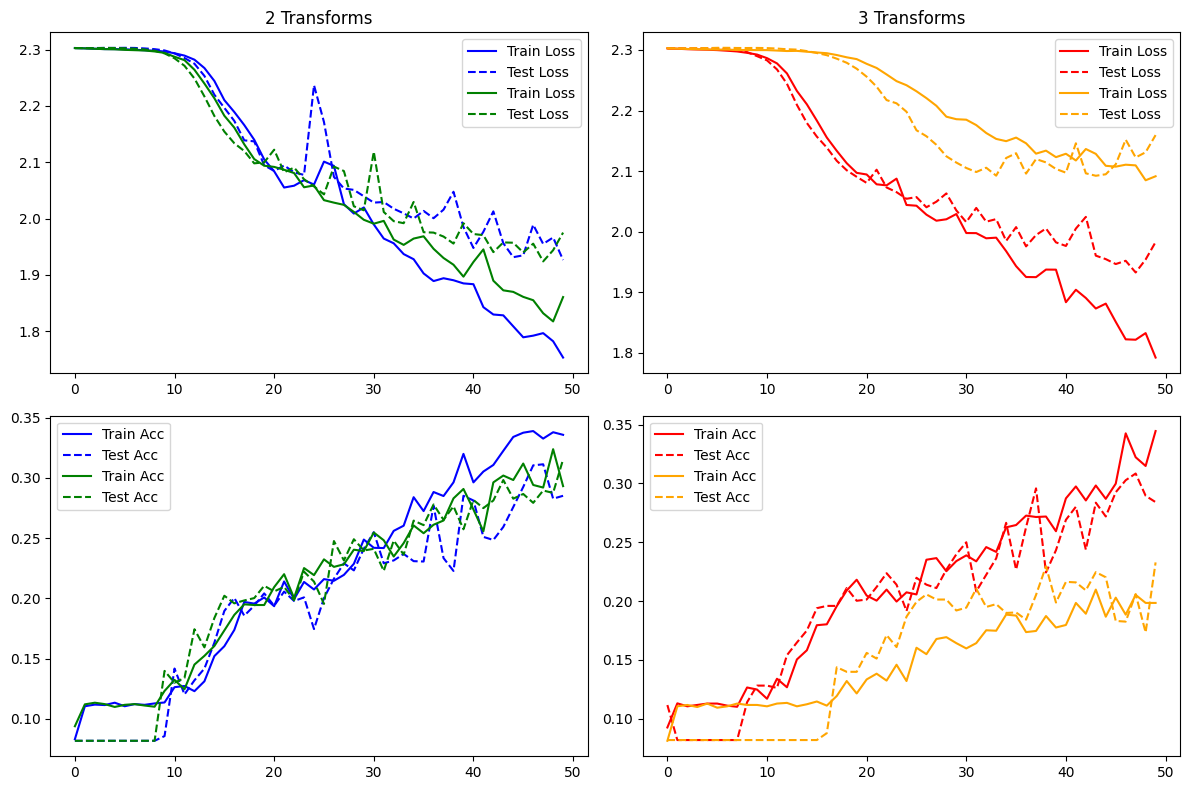

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import os

def load_cifar(subset_size=1000):
    try:
        train_ds = datasets.CIFAR10('./data', train=True, download=True)
        test_ds = datasets.CIFAR10('./data', train=False, download=True)
    except:
        print("Download failed, using synthetic data")
        # Synthetic
        N_TRAIN = subset_size
        N_TEST = 500
        train_data = [(torch.rand(3, 32, 32), torch.randint(0, 10, (1,)).item()) for _ in range(N_TRAIN)]
        test_data = [(torch.rand(3, 32, 32), torch.randint(0, 10, (1,)).item()) for _ in range(N_TEST)]
        return train_data, test_data, True

    def numpy_to_tensor(img_np):
        if img_np.shape != (32, 32, 3):
            img_np = np.squeeze(img_np)
        tensor = torch.from_numpy(img_np.transpose(2, 0, 1)).float() / 255.0
        return tensor

    train_data = []
    for i in range(min(subset_size, len(train_ds))):
        img = numpy_to_tensor(train_ds.data[i])
        label = train_ds.targets[i]
        train_data.append((img, label))

    test_data = []
    for i in range(min(500, len(test_ds))):
        img = numpy_to_tensor(test_ds.data[i])
        label = test_ds.targets[i]
        test_data.append((img, label))

    return train_data, test_data, False

train_data, test_data, is_synthetic = load_cifar(1000)
print(f"Using synthetic: {is_synthetic}")

class SimpleDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, torch.tensor(label, dtype=torch.long)

# Слои (из задания 2)
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.bias = None

    def __call__(self, x):
        out = torch.matmul(x, self.weight.T)
        if self.bias is not None:
            out += self.bias
        return out

    def parameters(self):
        params = [self.weight]
        if self.bias is not None:
            params.append(self.bias)
        return params

class ReLU:
    def __call__(self, x):
        return F.relu(x)

class Dropout:
    def __init__(self, p=0.2):
        self.p = p

    def __call__(self, x, training=True):
        if not training:
            return x
        mask = (torch.rand_like(x) > self.p).float()
        return x * mask / (1 - self.p)

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer(x, training)
            else:
                x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            if hasattr(layer, 'parameters'):
                params.extend(layer.parameters())
        return params

class Net(Sequential):
    def __init__(self):
        super().__init__([
            Linear(3*32*32, 128), ReLU(), Dropout(0.2),
            Linear(128, 64), ReLU(), Dropout(0.2),
            Linear(64, 10)
        ])

class RandomCropTensor:
    def __init__(self, p=0.5, size=24):
        self.p = p
        self.size = size

    def __call__(self, tensor):
        if np.random.rand() < self.p:
            i = np.random.randint(0, 32 - self.size + 1)
            j = np.random.randint(0, 32 - self.size + 1)
            cropped = tensor[:, i:i+self.size, j:j+self.size]
            if self.size != 32:
                # unsqueeze(0) один раз -> (1, 3, 24, 24)
                cropped = F.interpolate(cropped.unsqueeze(0), size=(32, 32), mode='bilinear').squeeze(0)
            return cropped
        return tensor

class RandomRotateTensor:
    def __init__(self, p=0.5, degrees=15):
        self.p = p
        self.degrees = degrees

    def __call__(self, tensor):
        if np.random.rand() < self.p:
            angle = np.random.uniform(-self.degrees, self.degrees) * np.pi / 180
            cos, sin = np.cos(angle), np.sin(angle)
            theta = torch.tensor([[cos, -sin, 0], [sin, cos, 0]], dtype=torch.float32).unsqueeze(0)
            # shape от tensor.unsqueeze(0)
            grid = F.affine_grid(theta, tensor.unsqueeze(0).shape, align_corners=False)
            # unsqueeze(0) один раз
            rotated = F.grid_sample(tensor.unsqueeze(0), grid, align_corners=False)
            return rotated.squeeze(0)
        return tensor

class RandomZoomTensor:
    def __init__(self, p=0.5, zoom_range=(0.8, 1.2)):
        self.p = p
        self.zoom_min, self.zoom_max = zoom_range

    def __call__(self, tensor):
        if np.random.rand() < self.p:
            z = np.random.uniform(self.zoom_min, self.zoom_max)
            scale = z
            tx = (1 - scale) * 16  # Center zoom
            theta = torch.tensor([[scale, 0, tx], [0, scale, tx]], dtype=torch.float32).unsqueeze(0)
            grid = F.affine_grid(theta, tensor.unsqueeze(0).shape, align_corners=False)
            zoomed = F.grid_sample(tensor.unsqueeze(0), grid, align_corners=False)
            return zoomed.squeeze(0)
        return tensor

class ComposeTensor:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, tensor):
        for t in self.transforms:
            tensor = t(tensor)
        return tensor

def train_model(num_trans=0, p=0.5, epochs=50, subset_size=1000, use_tb=False):
    train_data, test_data, _ = load_cifar(subset_size)
    trans_list = []
    if num_trans >= 1:
        trans_list.append(RandomCropTensor(p, size=24))
    if num_trans >= 2:
        trans_list.append(RandomRotateTensor(p))
    if num_trans >= 3:
        trans_list.append(RandomZoomTensor(p))
    comp = ComposeTensor(trans_list)

    # Apply to train
    train_transformed = [(comp(img.clone()), label) for img, label in train_data]
    train_ds_t = SimpleDataset(train_transformed)
    train_loader = DataLoader(train_ds_t, batch_size=64, shuffle=True)

    test_ds_t = SimpleDataset(test_data)
    test_loader = DataLoader(test_ds_t, batch_size=64)

    model = Net()
    opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    losses_train, accs_train = [], []
    losses_test, accs_test = [], []

    writer = SummaryWriter(f'runs/case{num_trans}') if use_tb else None

    for epoch in range(epochs):
        # Train
        train_loss, train_acc = 0, 0
        n_batches = 0
        for imgs, labels in train_loader:
            imgs = imgs.view(imgs.size(0), -1)
            out = model(imgs, training=True)
            loss = F.cross_entropy(out, labels)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item()
            pred = out.argmax(1)
            train_acc += (pred == labels).float().mean().item()
            n_batches += 1

        avg_train_loss = train_loss / n_batches
        avg_train_acc = train_acc / n_batches
        losses_train.append(avg_train_loss)
        accs_train.append(avg_train_acc)

        # Test
        with torch.no_grad():
            test_loss, test_acc = 0, 0
            n_test = 0
            for imgs, labels in test_loader:
                imgs = imgs.view(imgs.size(0), -1)
                out = model(imgs, training=False)
                loss = F.cross_entropy(out, labels)
                test_loss += loss.item()
                pred = out.argmax(1)
                test_acc += (pred == labels).float().mean().item()
                n_test += 1

            avg_test_loss = test_loss / n_test
            avg_test_acc = test_acc / n_test
            losses_test.append(avg_test_loss)
            accs_test.append(avg_test_acc)

        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Acc/Train', avg_train_acc, epoch)
            writer.add_scalar('Loss/Test', avg_test_loss, epoch)
            writer.add_scalar('Acc/Test', avg_test_acc, epoch)

    if writer:
        writer.close()

    return losses_train, accs_train, losses_test, accs_test

# Запуск случаев
cases = [0, 1, 2, 3]
results = {}
for num in cases:
    print(f"Running case {num}...")
    lt, at, ls, ast = train_model(num_trans=num, epochs=50, subset_size=1000, use_tb=False)
    results[num] = (lt, at, ls, ast)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange']
for i, num in enumerate(cases):
    lt, at, ls, ast = results[num]
    row, col = i // 2, i % 2
    axs[0, col].plot(lt, label='Train Loss', color=colors[i])
    axs[0, col].plot(ls, label='Test Loss', color=colors[i], linestyle='--')
    axs[0, col].set_title(f'{num} Transforms')
    axs[0, col].legend()

    axs[1, col].plot(at, label='Train Acc', color=colors[i])
    axs[1, col].plot(ast, label='Test Acc', color=colors[i], linestyle='--')
    axs[1, col].legend()
plt.tight_layout()
plt.show()